In [42]:
from scripts import support, metrics, vectorization as v, aggregation
from scripts.gras import GRAS
from scripts.kuroda import kuroda
from scripts.insd import insd
from scripts.nras import nras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import gurobipy as gr
from scipy.sparse import csr_matrix
%matplotlib inline

In [43]:
!pip install --upgrade pandas==1.0.0rc0

Requirement already up-to-date: pandas==1.0.0rc0 in c:\users\maksim komatovskiy\anaconda3\lib\site-packages (1.0.0rc0)


In [44]:
#!conda install gurobi

# 1. Таблицы ресурсов

## 1.1. Препроцессинг (с агрегированием)

### Таблица ресурсов за 2011 год

Загружаем базовую таблицу ресурсов за 2011 год.

In [45]:
# Базовая таблица РЕСУРСОВ за 2011

df = pd.read_excel("./data/baz2011.xlsx", "ТР")
df = df.iloc[1:-3,3:-7]
df = df.fillna(0)

supply2011_codes = df.drop(df.index[[1]], axis=0) # таблица 2011 года с кодами
supply2011 = df.drop(df.index[[0,1]], axis=0) # таблица 2011 года без кодов

print('Размер базовой таблицы ресурсов за 2011 год: ', supply2011.shape)

Размер базовой таблицы ресурсов за 2011 год:  (248, 178)


##### __Агрегирование по отраслям (столбцы)__

Поскольку степени агрегации для 2011 и 2016 годов различны, сделаем единую систему: будем объединять все отрасли с одинаковым начальным номером (проверяем первые две цифры), суммируя внутренние значения. 

In [46]:
# В строке с кодами оставим только первые два символа - по ним и будем объединять

for i in range(178):
    a = str(supply2011_codes.loc[1][i])
    a = a[:2]
    supply2011_codes.loc[1][i] = a
    
supply2011_codes.columns = supply2011_codes.iloc[0] # сделали преобразованную строку с кодами -- заголовками
supply2011_codes = supply2011_codes.drop(supply2011_codes.index[0]) # избавились от отдельной строки с кодами

supply2011_codes = supply2011_codes.groupby(supply2011_codes.columns, axis=1).sum() # объединили данные в таблице по одинаковым столбцам
                                                                              # (внутри суммируем)

##### __Агрегирование по продуктам (строки)__

In [47]:
# Создаем функцию, которая будет отрезать первые две цифры кода продукта

def splitter(x):    
    a = str(x)
    a=a[:2]
    return a

df = pd.read_excel("./data/baz2011.xlsx", "ТР") # считали столбец с кодами
df = df.iloc[3:-3,1:2]
df = df.fillna(0)
supply2011_codes['codes_prod'] = df

supply2011_codes['codes_prod'] = supply2011_codes['codes_prod'].apply(lambda x: splitter(x))  # преобразовали все коды до двух цифр
supply2011_codes = supply2011_codes.groupby(supply2011_codes['codes_prod']).sum() # сгруппировали

put_cell 19 28


KeyboardInterrupt: 

##### __Векторизация__

In [ ]:
agg_supply2011 = supply2011_codes # теперь agg_supply2011 - агрегированная версия таблицы за 2011 год

agg_supply2011_arr = np.array(supply2011_codes)
agg_supply2011_vec = v.tovector(agg_supply2011_arr).astype(float)

### Таблица ресурсов за 2016 год

In [ ]:
# базовая таблица РЕСУРСОВ за 2016

df = pd.read_excel("./data/baz2016.xlsx", "ТР ")
df = df.iloc[1:-3,3:-7]
df = df.fillna(0)

supply2016_codes = df.drop(df.index[[1]], axis=0) # таблица 2011 года с кодами
supply2016 = df.drop(df.index[[0,1]], axis=0) # таблица 2011 года без кодов

show_supply2016_codes = supply2016_codes # сохранили, чтобы была возможность в любой момент посмотреть таблицу
show_supply2016 = supply2016

print('Размер базовой таблицы ресурсов за 2011 год: ', supply2016.shape)

supply2016 = np.array(df.drop(df.index[[0,1]], axis=0))
supply2016 = v.tovector(supply2016).astype(float) # векторизовали

##### __Агрегирование по отраслям (столбцы)__

In [ ]:
for i in range(98):
    a = str(supply2016_codes.loc[1][i])
    a = a[:2]
    supply2016_codes.loc[1][i] = a
    
supply2016_codes.columns = supply2016_codes.iloc[0] # сделали преобразованную строку с кодами -- заголовками
supply2016_codes = supply2016_codes.drop(supply2016_codes.index[0]) # избавились от отдельной строки с кодами

supply2016_codes = supply2016_codes.groupby(supply2016_codes.columns, axis=1).sum() # объединили данные в таблице по одинаковым столбцам
                                                                              # (внутри суммируем)

##### __Агрегирование по продуктам (строки)__

In [ ]:
df = pd.read_excel("./data/baz2016.xlsx", "ТР ") # считали столбец с кодами
df = df.iloc[3:-3,1:2]
df = df.fillna(0)
supply2016_codes['codes_prod'] = df

supply2016_codes['codes_prod'] = supply2016_codes['codes_prod'].apply(lambda x: splitter(x))  # преобразовали все коды до двух цифр
supply2016_codes = supply2016_codes.groupby(supply2016_codes['codes_prod']).sum() # сгруппировали

##### __Векторизация__

In [ ]:
agg_supply2016 = supply2016_codes

agg_supply2016_arr = np.array(supply2016_codes)
agg_supply2016_vec = v.tovector(agg_supply2016_arr).astype(float)

#### Проверка:
Считаем файл с готовой агрегацией (`aggregated2011.xls`) и сверим нашу агрегацию с готовой.

In [ ]:
df = pd.read_excel("./data/aggregated2011.xls", "ТР")
df = df.iloc[3:-3,3:-6]
df = df.fillna(0)

new_2011 = df

In [ ]:
((np.array(agg_supply2011)-np.array(new_2011))**2).sum()

#### Подготовим таблицы к проекции

In [ ]:
# Занулим элементы, в которых меняется знак

agg_supply2011[agg_supply2011 * agg_supply2016 < 0] = 0
agg_supply2016[agg_supply2011 * agg_supply2016 < 0] = 0

In [ ]:
# Считаем суммы по строкам и столбцам

# Для 2011 года:
rows_sums_agg_supply2011 = np.sum(agg_supply2011, axis=1)
columns_sums_agg_supply2011 = np.sum(agg_supply2011, axis=0)
totals_agg_supply2011 = np.concatenate((rows_sums_agg_supply2011, columns_sums_agg_supply2011)).astype(float)[np.newaxis].T

# Для 2016 года:
rows_sums_agg_supply2016 = np.sum(agg_supply2016, axis=1)
columns_sums_agg_supply2016 = np.sum(agg_supply2016, axis=0)
totals_agg_supply2016 = np.concatenate((rows_sums_agg_supply2016, columns_sums_agg_supply2016)).astype(float)[np.newaxis].T

### SVD

## 1.2. Проекция

In [ ]:
# from scripts import support, metrics, vectorization as v, aggregation

def projection(method_name, bench_matrix, constraints, target_matrix, sparsed = True, save = True, totals = False):
    """
    Получение результата эксперимента

    Parameters
    ----------
    tables_kind: string
        степень аггрегации таблиц
    method_name: string
        метод для получения новой матрицы
    bench_matrix: np.array или sparse матрица
        бенчмарк таблица
    constraints: np.array или sparse матрица
        матрица ограничений
    target_matrix: np.array или sparse матрица
        целевая таблица
    experiment_type: string
        агрегация\дезаггрегация\проекция
    sparse: bool
        использовать sparse матрицу или np.array
    Returns
    -------
    a: float
        значение метрики
    """
    
    m = 59
    n = 59
    table_size = (m, n)    

    ttls = v.addrows((m,n))
    g = v.addcolumns((m,n), ttls)      
    
    if sparsed:
        g = csr_matrix(g)

    if totals:
        g_w_totals = v.addrows((m,n), G, sparsed=sparsed)
        g_w_totals = v.addcolumns((m,n), g_w_totals, sparsed=sparsed)

    if method_name in ['kuroda_1', 'kuroda_2', 'kuroda_3']:
        method, kuroda_type = method_name.split('_')
        method = eval(method)
        results = np.round(method(g, eval(bench_matrix), eval(constraints), mtype=int(kuroda_type), sparsed=sparsed))

    else:
        method = eval(method_name)
        results = method(g, eval(bench_matrix), eval(constraints), sparsed=sparsed)

    metrics_values = metrics.get_values(np.round(results), eval(target_matrix), save=True)
    
    # Save metrics' results
    if save:
        info = {'method':method_name, 'target_matrix':target_matrix, 
                'constraints':constraints, 'bench_matrix':bench_matrix}
        info = {**info,**metrics_values}

        res_table = pd.read_excel('results/results.xlsx')
        res_table = res_table.append([info])
        res_table.to_excel('results/results.xlsx', index=None,encoding='utf-8')

    return metrics_values, g

def projection_for_all_methods(bench_matrix, constraints, target_matrix, totals = False):
    methods_list = ['nras','insd','kuroda_3','kuroda_2','kuroda_1']
    sparsed = True
    for i, method in enumerate(methods_list):
        print('Method:', method)
        if i > 2:
            sparsed = False
        projection(method, bench_matrix, constraints, target_matrix, sparsed = sparsed, totals = totals)
            

### Реализация метода GRAS c ограничениями по строкам и столбцам (вычисления не векторизованы, в данном случае быстрее)

In [48]:
import logging
import traceback
import numpy as np  
import pandas as pd

In [49]:
A = agg_supply2011_vec.reshape(59,59)
X = agg_supply2016_vec.reshape(59,59)

In [50]:
AA = pd.DataFrame(A)
AA.to_csv('supply_2011.csv')
XX = pd.DataFrame(X)
XX.to_csv('supply_2016.csv')

Реализуем функцию качества, основанную на расстоянии Кульбака-Лейблера:

$$ \min\limits_{z_{ij}} \sum\limits_{i,j} |a_{ij}| z_{ij}log(\frac{z_{ij}}{e})}$$

In [51]:
def quality_function(X,A):
    
    '''
    X - np.ndarray matrix - матрица, которую проверяем на близость с А
    
    A - np.ndarray matrix - базовая матрица
    '''  
    abs_A = np.abs(A)
    Z = X/A
    ln = np.log(Z/np.exp(1))
    M = abs_A*Z*ln
    M = np.sum(M)
    return M

In [52]:
def P_N_masks(A):
    
    '''
    Раскладывает матрицу А на разность двух матриц: с положительными элементами и модулем отрицательных
    '''
    P_mask = [A>=0]
    P_mask = np.array(P_mask)[0]
    P_mask = P_mask.astype(float)
    
    N_mask = [A<0]
    N_mask = np.array(N_mask)[0]
    N_mask = N_mask.astype(float)
    
    return P_mask, N_mask

def split_A_to_PN(A):
    
    '''
    Выдает две матрицы - с положительными элементами и модулями отрицательных 
    
    '''
    
    P = P_N_masks(A)[0] * A
    N = np.abs(P_N_masks(A)[1] * A)
    
    return P,N   

In [53]:
P = split_A_to_PN(A)[0]
N = P = split_A_to_PN(A)[1]

In [54]:
'''
Научимся выводит векторы ограничений на строки и столбцы. Вообще они будут заданы, но вдруг

'''

def define_u_vector(X):
    u = []
    for rows in X:
        u.append(np.sum(rows))
    return(np.array(u))


    
def define_v_vector(X):
    X = np.array(pd.DataFrame(X).T)
    v = []
    for rows in X:
        v.append(np.sum(rows))
    return(np.array(v))



In [55]:
u = define_u_vector(X)
v = define_v_vector(X)

### Итерации

В начале полагаем вектор r(0) равным единичному (т.е. левое преобразование - тривиальное отображение в себя).

Затем используем решение Темуршоева чтобы итеративно вычислить все элементы корректировочной матрицы для строк (правое преобразование):

$$ \begin{cases}
s_j = \dfrac{v_j + \sqrt{v^2_j + 4 p_j(r)n_j(r)}}{2p_j(r)}\\
p_j(r) = \sum\limits_{i}r_ip_{ij}\\
n_j(r) = \sum\limits_i \dfrac{n_{ij}}{r_i}
\end{cases}$$





In [56]:
r = np.ones(A.shape[0]) # создали единичный вектор


def count_p_ij(r,P):
    res =(r.reshape(1,-1))@P
    return np.sum(res, axis = 0)

def count_n_ij(r,N):
    r = 1/r
    res = (r.reshape(1,-1))@N
    return np.sum(res, axis = 0)

print(count_p_ij(r,P))
print(count_n_ij(r,N))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Дело за малым, осталось по первой формуле из системы вычислить элементы $s_j$ (решение квадратного уравнения):

In [57]:
'''
Вектора u и v на данный момент полагаются известными (да, мы их знаем, либо экзогенно, либо из истинной матрицы X)
'''


def count_s_j(r,P,N,v):
    p = count_p_ij(r,P)
    n = count_n_ij(r,N)
    
    sqr = np.sqrt(v**2 + 4*p*n)
    s = (v + sqr)/(2*p)
    return s

In [58]:
s = count_s_j(r,P,N,v) # работает, осталось верно все это дело расположить

### Обратная итерация

Теперь полагаем известным некоторый вектор $s$ и организуем пересчет вектора r, затем объединим все в одну функцию и будем чередовать до тех пор пока не сойдемся с нужной точностью.
У ТЕМУРШОЕВА ТУТ ОПЕЧАТКА.


$$ \begin{cases}
r_i = \dfrac{u_i + \sqrt{u^2_i + 4 p_i(s)n_i(s)}}{2p_i(s)}\\
p_i(s) = \sum\limits_j p_{ij}s_j\\
n_i(s) = \sum\limits_{j} \dfrac{n_{ij}}{s_j}
\end{cases}$$

In [59]:
def count_p_ij_s(s,P):
    res = np.dot(P,s.reshape(-1,1))
    return np.sum(res, axis = 1)

def count_n_ij_s(s,N):
    s = 1/s
    res = N@(s.reshape(-1,1))
    return np.sum(res, axis = 1)


def count_r_i(s,P,N,u):
    p = count_p_ij_s(s,P)
    n = count_n_ij_s(s,N)
    
    sqr = np.sqrt(u**2 + 4*p*n)
    s = (u + sqr)/(2*p)
    return s

### Сборка.

Все предварительные операции отлажены, начнем сборку. На вход подается, например, базовая матрица A, вектора ограничений (заранее известные). На выход необходимо подать результирующую матрицу X с заранее известной (также подается) точностью $\epsilon$.

План действий:

* получаем матрицу A

* раскладываем на P,N

* полагаем начальный вектор r единичным

* итерируемся до тех пор, пока разница между предыдущим r и новым не станет меньше заранее заданной точности

* действуем на матрицу А слева и справа итоговыми преобразованиями, выводим матрицу Х, считаем функцию качества

In [60]:

import copy



'''
Разделяем матрицу
'''

P = split_A_to_PN(A)[0]

N = split_A_to_PN(A)[1]


'''
Тривиальное левое преобразование
'''

r = np.ones(A.shape[0])

''' 
Задаем интересующую нас точность (пока на r)
'''

eps = 1e-7


'''
До тех пор, пока предыдущий вектор r (какая разница) 
не будет отличаться от следующего меньше чем на eps,
итерируемся туда-обратно
'''

memory = np.zeros(len(r))
counter = 0
limit = 1e2

while np.linalg.norm(r - memory) > eps and counter < limit:
    
    s = count_s_j(r,P,N,v)
    memory = r.copy()
    r = count_r_i(s,P,N,u)
    counter  += 1
print(counter)
#print(r)
#print(s)

100


In [61]:
RESULT = np.diag(r)@A@np.diag(s)

In [62]:
print('Качество подгонки вектора ограничений по строкам: \n')

np.round(RESULT.sum(axis = 1),2) - u

Качество подгонки вектора ограничений по строкам: 



array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [63]:
print('Качество подгонки вектора ограничений по столбцам: \n')

np.round(RESULT.sum(axis = 0),2) - v 

Качество подгонки вектора ограничений по столбцам: 



array([-4.002900e+02,  1.008000e+01, -1.385000e+01,  4.447000e+01,
        5.136200e+02, -4.208000e+01,  2.185000e+01,  3.725000e+01,
       -4.152600e+02,  9.403100e+02,  9.400000e+00,  8.980000e+00,
        4.360000e+00,  2.076000e+01,  3.273000e+01,  2.862000e+01,
        3.653500e+02,  1.317100e+02,  5.230000e+01,  5.402000e+01,
        2.312100e+02,  5.992000e+01,  8.759000e+01,  5.810000e+00,
        4.610000e+01,  4.215000e+01,  4.798000e+01,  2.253600e+02,
        1.879500e+02,  2.260000e+01,  1.594000e+01,  7.858000e+01,
        5.200000e+00,  4.116000e+02,  1.689500e+02,  5.276200e+02,
        1.664100e+02,  1.681200e+02,  3.696400e+02,  8.710000e+00,
        1.125500e+02,  2.323600e+02,  1.364040e+03,  7.228140e+03,
        1.598870e+03,  3.345000e+02,  9.375000e+02,  1.169700e+02,
        1.256300e+02,  1.135800e+02, -4.543400e+02, -2.361807e+04,
        5.141820e+03,  1.377140e+03,  8.860000e+00,  1.355000e+01,
        1.065370e+03,  2.108000e+01, -1.360000e+00])

In [64]:
print('Значение метрики MAPE: {}'.format(metrics.mape(X,RESULT)))
print(' ')
print('Значение метрики WAPE: {} '.format(metrics.wape(X,RESULT)))
print()
print('Значение метрики PsiStat: {}'.format(metrics.PsiStat(X,RESULT)))
print(' ')
print('Значение метрики SWAD: {} '.format(metrics.swad(X,RESULT)))
print(' ')
print('Значение метрики RSQ: {} '.format(metrics.RSQ(X,RESULT)))
print(' ')
print('Значение метрики N0: {} '.format(metrics.N0(X,RESULT)))

Значение метрики MAPE: 130.992999914765
 
Значение метрики WAPE: 3.0920745380635513 

Значение метрики PsiStat: 0.006153357225277205
 
Значение метрики SWAD: 0.00565618367793114 
 
Значение метрики RSQ: 0.9998167368793851 
 
Значение метрики N0: 429 


### Стохастический вариант GRAS с выбором по невязкам сумм строк и столбцов



In [34]:
A = agg_supply2011_vec.reshape(59,59)
X = agg_supply2016_vec.reshape(59,59)

In [35]:
def count_masked_r(k,r,s,u,A):
    diff_vector = np.abs(np.diag(r)@A@np.diag(s).sum(axis = 1) - u)
    #print(diff_vector)
    threshold = np.sort(diff_vector)[-k]
    #print(threshold)
    r_masked = [diff_vector>=threshold]
    return np.array(r_masked)[0]

In [36]:
def count_masked_s(k,r,s,u,A):
    diff_vector = np.abs(np.diag(r)@A@np.diag(s).sum(axis = 0) - v)
    #print(diff_vector)
    threshold = np.sort(diff_vector)[-k]
    #print(threshold)
    s_masked = [diff_vector>threshold]
    return np.array(s_masked)[0]

In [37]:

import copy

k = 1

P = split_A_to_PN(A)[0]

N = split_A_to_PN(A)[1]


r = np.ones(A.shape[0])

eps = 1e-7
norm_vector = []
arg_vector = []
memory_r = np.ones(len(r))/2
counter = 0
limit = 3e3
update_counter = 0

while np.linalg.norm(r - memory_r) > eps and counter < limit:
    
    r_masked = r*count_masked_r(k,r,s,u,A) + memory_r*~count_masked_r(k,r,s,u,A)
    s = count_s_j(r_masked,P,N,v)
    memory_s = s.copy()
    update_counter += k
    memory_r = r.copy()
    s_masked = s*count_masked_s(k,r,s,u,A) + memory_s*~count_masked_s(k,r,s,u,A)
    r = count_r_i(s_masked,P,N,u)
    #update_counter += k
    result = np.diag(r)@A@np.diag(s)
    norm_vector.append(np.linalg.norm(X - result))
    arg_vector.append(update_counter)
    counter  += 1
print(counter)
print(update_counter)
#print(r)
#print(s)

3000
3000


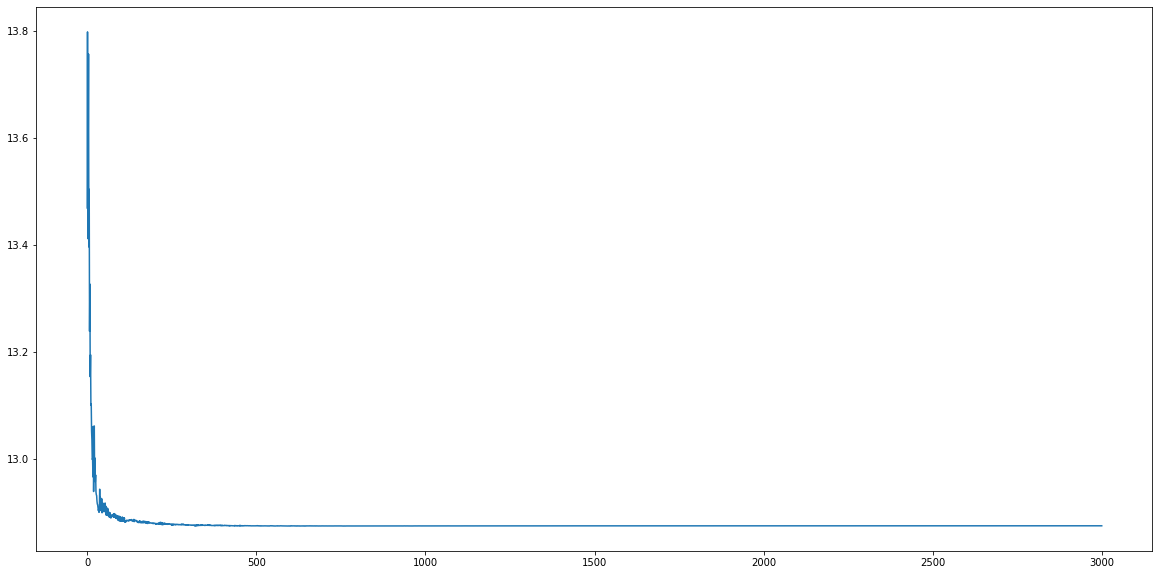

In [38]:
plt.figure(figsize = (20,10))
plt.plot(np.log(norm_vector))

In [39]:
# потом завернем все это в функцию, пока прост с ячейкой поработаем
import copy



'''
Разделяем матрицу
'''

P = split_A_to_PN(A)[0]

N = split_A_to_PN(A)[1]


'''
Тривиальное левое преобразование
'''

r = np.ones(A.shape[0])

''' 
Задаем интересующую нас точность (пока на r)
'''

eps = 1e-7
norm_vector_2 = []
arg_vector_2 = []
'''
До тех пор, пока предыдущий вектор r (какая разница) 
не будет отличаться от следующего меньше чем на eps,
итерируемся туда-обратно
'''

memory = np.ones(len(r))/2
counter = 0
updates_counter = 0
limit = 5e1

while np.linalg.norm(r - memory) > eps and counter < limit:
    
    s = count_s_j(r,P,N,v)
    updates_counter +=59
    memory = r.copy()
    r = count_r_i(s,P,N,u)
    counter  += 1
    result = np.diag(r)@A@np.diag(s)
    norm_vector_2.append(np.linalg.norm(X - result))
    arg_vector_2.append(updates_counter)
print(counter)
#print(r)
#print(s)

50


In [40]:
norm_vector = np.array(norm_vector)
norm_vector_2 = np.array(norm_vector_2)

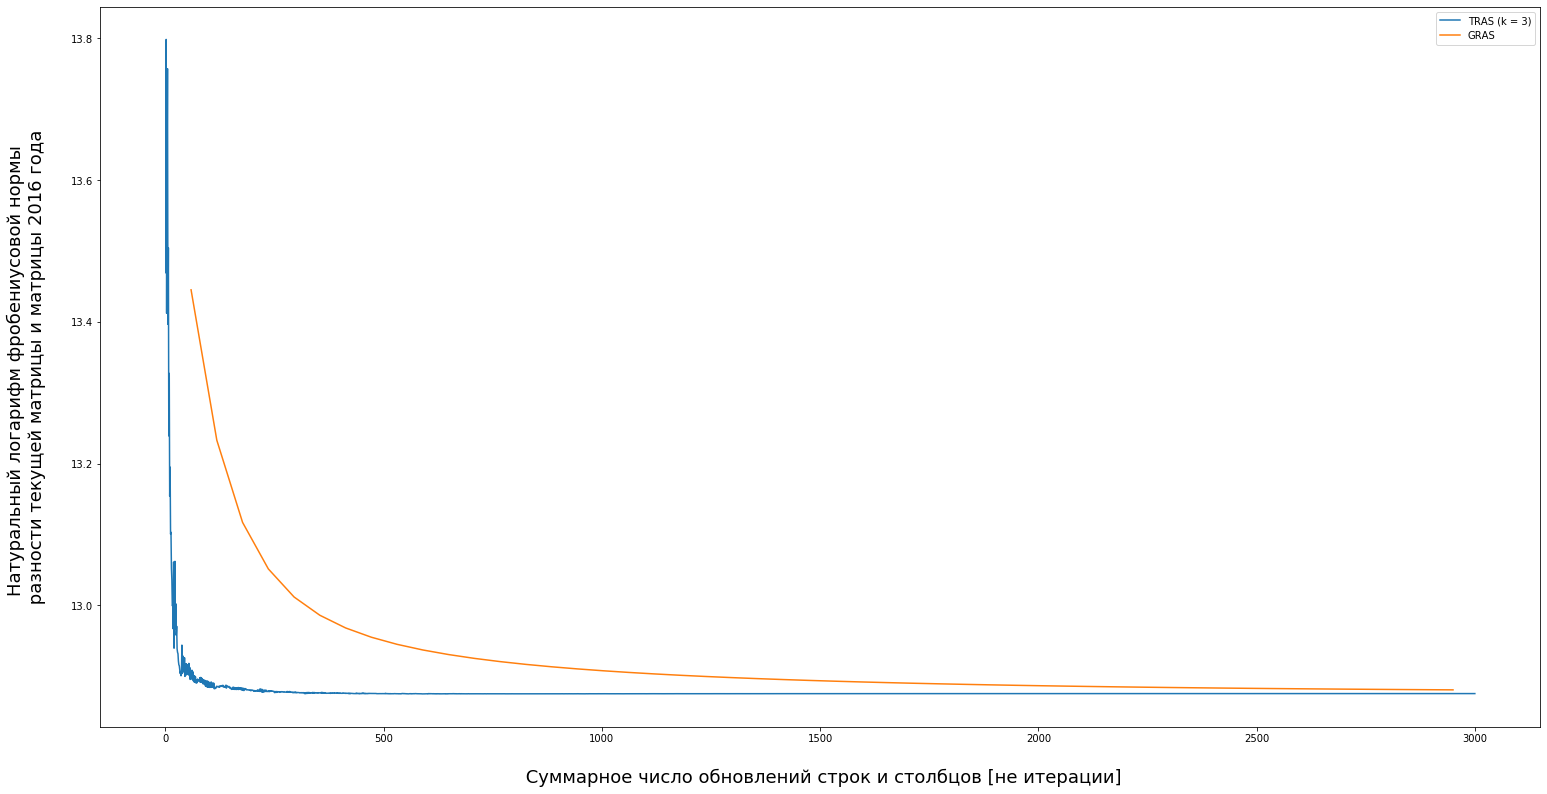

In [41]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_axes([0,0,1,1])
ax.plot(arg_vector,np.log(norm_vector),label = 'TRAS (k = 3)')
ax.plot(arg_vector_2,np.log(norm_vector_2),label = 'GRAS')
ax.set_xlabel(' \n Суммарное число обновлений строк и столбцов [не итерации]',fontsize = 18)
ax.set_ylabel('Натуральный логарифм фробениусовой нормы \n разности текущей матрицы и матрицы 2016 года \n',fontsize = 18)
ax.legend()

# Проекция остальными методами

In [ ]:
projection_for_all_methods('agg_supply2011_vec', 'totals_agg_supply2016', 'agg_supply2016_vec') 

# 2. Таблицы использования в ценах потребителей

## 2.1. Препроцессинг

### Таблица использования в ценах потребителей за 2011 год

In [ ]:
from scripts import vectorization

In [ ]:
df = pd.read_excel("./data/aggregated2011.xls", "ТИцп")
df = df.iloc[3:-11,3:-13]
df = df.fillna(0)

cons_use2011 = df

# Векторизуем
cons_use2011_arr = np.array(cons_use2011)
cons_use2011_vec = vectorization.tovector(cons_use2011_arr).astype(float)

# Посчитаем суммы по столбцам и строкам
rows_sums_cons_use2011 = np.sum(cons_use2011, axis=1)
columns_sums_cons_use2011 = np.sum(cons_use2011, axis=0)
totals_cons_use2011 = np.concatenate((rows_sums_cons_use2011, columns_sums_cons_use2011)).astype(float)[np.newaxis].T

### Таблица использования в ценах потребителей за 2016 год

In [ ]:
df = pd.read_excel("./data/aggregated2016.xls", "ТИцп")
df = df.iloc[3:-11,3:-13]
df = df.fillna(0)

cons_use2016 = df

# Векторизуем
cons_use2016_arr = np.array(cons_use2016)
cons_use2016_vec = vectorization.tovector(cons_use2016_arr).astype(float)

# Посчитаем суммы по столбцам и строкам
rows_sums_cons_use2016 = np.sum(cons_use2016, axis=1)
columns_sums_cons_use2016 = np.sum(cons_use2016, axis=0)
totals_cons_use2016 = np.concatenate((rows_sums_cons_use2016, columns_sums_cons_use2016)).astype(float)[np.newaxis].T

In [ ]:
# Занулим элементы, в которых меняется знак

cons_use2011[cons_use2011 * cons_use2016 < 0] = 0
cons_use2016[cons_use2011 * cons_use2016 < 0] = 0

### Проекция невекторизованным GRAS

In [ ]:
A = cons_use2011_vec.reshape(59,59) + 1e-2
X = cons_use2016_vec.reshape(59,59) + 1e-2

In [ ]:
import logging
import traceback
import numpy as np  
import pandas as pd

Реализуем функцию качества, основанную на расстоянии Кульбака-Лейблера:

$$ \min\limits_{z_{ij}} \sum\limits_{i,j} |a_{ij}| z_{ij}log(\frac{z_{ij}}{e})}$$

In [ ]:
def quality_function(X,A):
    
    '''
    X - np.ndarray matrix - матрица, которую проверяем на близость с А
    
    A - np.ndarray matrix - базовая матрица
    '''  
    abs_A = np.abs(A)
    Z = X/A
    ln = np.log(Z/np.exp(1))
    M = abs_A*Z*ln
    M = np.sum(M)
    return M

In [ ]:
def P_N_masks(A):
    
    '''
    Раскладывает матрицу А на разность двух матриц: с положительными элементами и модулем отрицательных
    '''
    P_mask = [A>=0]
    P_mask = np.array(P_mask)[0]
    P_mask = P_mask.astype(float)
    
    N_mask = [A<0]
    N_mask = np.array(N_mask)[0]
    N_mask = N_mask.astype(float)
    
    return P_mask, N_mask

def split_A_to_PN(A):
    
    '''
    Выдает две матрицы - с положительными элементами и модулями отрицательных 
    
    '''
    
    P = P_N_masks(A)[0] * A
    N = np.abs(P_N_masks(A)[1] * A)
    
    return P,N   

In [ ]:
P = split_A_to_PN(A)[0]
N = split_A_to_PN(A)[1]

In [ ]:
'''
Научимся выводит векторы ограничений на строки и столбцы. Вообще они будут заданы, но вдруг

'''

def define_u_vector(X):
    u = []
    for rows in X:
        u.append(np.sum(rows))
    return(np.array(u))


    
def define_v_vector(X):
    X = np.array(pd.DataFrame(X).T)
    v = []
    for rows in X:
        v.append(np.sum(rows))
    return(np.array(v))



In [ ]:
u = define_u_vector(X)
v = define_v_vector(X)

### Итерации

В начале полагаем вектор r(0) равным единичному (т.е. левое преобразование - тривиальное отображение в себя).

Затем используем решение Темуршоева чтобы итеративно вычислить все элементы корректировочной матрицы для строк (правое преобразование):

$$ \begin{cases}
s_j = \dfrac{v_j + \sqrt{v^2_j + 4 p_j(r)n_j(r)}}{2p_j(r)}\\
p_j(r) = \sum\limits_{i}r_ip_{ij}\\
n_j(r) = \sum\limits_i \dfrac{n_{ij}}{r_i}
\end{cases}$$





In [ ]:
r = np.ones(A.shape[0]) # создали единичный вектор


def count_p_ij(r,P):
    res =(r.reshape(1,-1))@P
    return np.sum(res, axis = 0)

def count_n_ij(r,N):
    r = 1/r
    res = (r.reshape(1,-1))@N
    return np.sum(res, axis = 0)


Дело за малым, осталось по первой формуле из системы вычислить элементы $s_j$ (решение квадратного уравнения):

In [ ]:
'''
Вектора u и v на данный момент полагаются известными (да, мы их знаем, либо экзогенно, либо из истинной матрицы X)
'''


def count_s_j(r,P,N,v):
    p = count_p_ij(r,P)
    n = count_n_ij(r,N)
    
    sqr = np.sqrt(v**2 + 4*p*n)
    #print(sqr)
    s = (v + sqr)/(2*p)
    return s

In [ ]:
s = count_s_j(r,P,N,v) # работает, осталось верно все это дело расположить

### Обратная итерация

Теперь полагаем известным некоторый вектор $s$ и организуем пересчет вектора r, затем объединим все в одну функцию и будем чередовать до тех пор пока не сойдемся с нужной точностью.
У ТЕМУРШОЕВА ТУТ ОПЕЧАТКА.


$$ \begin{cases}
r_i = \dfrac{u_i + \sqrt{u^2_i + 4 p_i(s)n_i(s)}}{2p_i(s)}\\
p_i(s) = \sum\limits_j p_{ij}s_j\\
n_i(s) = \sum\limits_{j} \dfrac{n_{ij}}{s_j}
\end{cases}$$

In [ ]:
def count_p_ij_s(s,P):
    res = np.dot(P,s.reshape(-1,1))
    return np.sum(res, axis = 1)

def count_n_ij_s(s,N):
    s = 1/s
    res = N@(s.reshape(-1,1))
    return np.sum(res, axis = 1)


def count_r_i(s,P,N,u):
    p = count_p_ij_s(s,P)
    n = count_n_ij_s(s,N)
    
    sqr = np.sqrt(u**2 + 4*p*n)
    r = (u + sqr)/(2*p)
    return r

### Сборка.

Все предварительные операции отлажены, начнем сборку. На вход подается, например, базовая матрица A, вектора ограничений (заранее известные). На выход необходимо подать результирующую матрицу X с заранее известной (также подается) точностью $\epsilon$.

План действий:

* получаем матрицу A

* раскладываем на P,N

* полагаем начальный вектор r единичным

* итерируемся до тех пор, пока разница между предыдущим r и новым не станет меньше заранее заданной точности

* действуем на матрицу А слева и справа итоговыми преобразованиями, выводим матрицу Х, считаем функцию качества

In [ ]:
# потом завернем все это в функцию, пока прост с ячейкой поработаем
import copy



'''
Разделяем матрицу
'''

P = split_A_to_PN(A)[0]

N = split_A_to_PN(A)[1]


'''
Тривиальное левое преобразование
'''

r = np.ones(A.shape[0])

''' 
Задаем интересующую нас точность (пока на r)
'''

eps = 1e-30


'''
До тех пор, пока предыдущий вектор r (какая разница) 
не будет отличаться от следующего меньше чем на eps,
итерируемся туда-обратно
'''

memory = np.zeros(len(r))
counter = 0
limit = 1000000

while np.linalg.norm(r - memory) > eps and counter < limit:
    
    s = count_s_j(r,P,N,v)
    memory = r.copy()
    r = count_r_i(s,P,N,u)
    counter  += 1
print(counter)
#print(r)
#print(s)

In [ ]:
RESULT = np.diag(r)@(A)@np.diag(s)

In [ ]:
r

In [ ]:
print('Качество подгонки вектора ограничений по строкам: \n')

np.round(RESULT.sum(axis = 1),2) - u

In [ ]:
print('Качество подгонки вектора ограничений по столбцам: \n')

np.round(RESULT.sum(axis = 0),2) - v 

In [ ]:
print('Значение метрики MAPE: {}'.format(metrics.mape(X-1,RESULT-1)))
print(' ')
print('Значение метрики WAPE: {} '.format(metrics.wape(X-1,RESULT-1)))
print()
print('Значение метрики PsiStat: {}'.format(metrics.PsiStat(X-1,RESULT-1)))
print(' ')
print('Значение метрики SWAD: {} '.format(metrics.swad(X-1,RESULT-1)))
print(' ')
print('Значение метрики RSQ: {} '.format(metrics.RSQ(X-1,RESULT-1)))
print(' ')
print('Значение метрики N0: {} '.format(metrics.N0(X-1,RESULT-1)))

## 2.2. Проекция

In [ ]:
#Эксперимент: проекция таблицы 2016 года из таблицы 2011 года
#Бенчмарк: cons_use2011_vec (таблица за 2011 год с максимальной агрегацией)
#Ограничения: таблица totals_2016
#Методы: NRAS, точность 0.01, 100 иттераций, INSD, Kuroda(1,2,3)

projection_for_all_methods('cons_use2011_vec', 'totals_cons_use2016', 'cons_use2016_vec')

# 3. Таблицы использования в основных ценах

## 3.1. Препроцессинг

### Таблица использования в основных ценах за 2011 год

In [ ]:
df = pd.read_excel("./data/aggregated2011.xls", "ТИоц")
df = df.iloc[3:-11,3:-13]
df = df.fillna(0)

basic_use2011 = df

# Векторизуем
basic_use2011_arr = np.array(basic_use2011)
basic_use2011_vec = vectorization.tovector(basic_use2011_arr).astype(float)

# Посчитаем суммы по столбцам и строкам
rows_sums_basic_use2011 = np.sum(basic_use2011, axis=1)
columns_sums_basic_use2011 = np.sum(basic_use2011, axis=0)
totals_basic_use2011 = np.concatenate((rows_sums_basic_use2011, columns_sums_basic_use2011)).astype(float)[np.newaxis].T

### Таблица использования в основных ценах за 2016 год

In [ ]:
df = pd.read_excel("./data/aggregated2016.xls", "ТИцп")
df = df.iloc[3:-11,3:-13]
df = df.fillna(0)

basic_use2016 = df

# Векторизуем
basic_use2016_arr = np.array(basic_use2016)
basic_use2016_vec = vectorization.tovector(basic_use2016_arr).astype(float)

# Посчитаем суммы по столбцам и строкам
rows_sums_basic_use2016 = np.sum(basic_use2016, axis=1)
columns_sums_basic_use2016 = np.sum(basic_use2016, axis=0)
totals_basic_use2016 = np.concatenate((rows_sums_basic_use2016, columns_sums_basic_use2016)).astype(float)[np.newaxis].T

In [ ]:
# Занулим элементы, в которых меняется знак

basic_use2011[basic_use2011 * basic_use2016 < 0] = 0
basic_use2016[basic_use2011 * basic_use2016 < 0] = 0

### Проекция невекторизованным GRAS

In [ ]:
A = basic_use2011_vec.reshape(59,59) + 1e-0
X = basic_use2016_vec.reshape(59,59) + 1e-0

In [ ]:
import logging
import traceback
import numpy as np  
import pandas as pd

Реализуем функцию качества, основанную на расстоянии Кульбака-Лейблера:

$$ \min\limits_{z_{ij}} \sum\limits_{i,j} |a_{ij}| z_{ij}log(\frac{z_{ij}}{e})}$$

In [ ]:
def quality_function(X,A):
    
    '''
    X - np.ndarray matrix - матрица, которую проверяем на близость с А
    
    A - np.ndarray matrix - базовая матрица
    '''  
    abs_A = np.abs(A)
    Z = X/A
    ln = np.log(Z/np.exp(1))
    M = abs_A*Z*ln
    M = np.sum(M)
    return M

In [ ]:
def P_N_masks(A):
    
    '''
    Раскладывает матрицу А на разность двух матриц: с положительными элементами и модулем отрицательных
    '''
    P_mask = [A>=0]
    P_mask = np.array(P_mask)[0]
    P_mask = P_mask.astype(float)
    
    N_mask = [A<0]
    N_mask = np.array(N_mask)[0]
    N_mask = N_mask.astype(float)
    
    return P_mask, N_mask

def split_A_to_PN(A):
    
    '''
    Выдает две матрицы - с положительными элементами и модулями отрицательных 
    
    '''
    
    P = P_N_masks(A)[0] * A
    N = np.abs(P_N_masks(A)[1] * A)
    
    return P,N   

In [ ]:
P = split_A_to_PN(A)[0]
N = split_A_to_PN(A)[1]

In [ ]:
'''
Научимся выводит векторы ограничений на строки и столбцы. Вообще они будут заданы, но вдруг

'''

def define_u_vector(X):
    u = []
    for rows in X:
        u.append(np.sum(rows))
    return(np.array(u))


    
def define_v_vector(X):
    X = np.array(pd.DataFrame(X).T)
    v = []
    for rows in X:
        v.append(np.sum(rows))
    return(np.array(v))



In [ ]:
u = define_u_vector(X)
v = define_v_vector(X)

### Итерации

В начале полагаем вектор r(0) равным единичному (т.е. левое преобразование - тривиальное отображение в себя).

Затем используем решение Темуршоева чтобы итеративно вычислить все элементы корректировочной матрицы для строк (правое преобразование):

$$ \begin{cases}
s_j = \dfrac{v_j + \sqrt{v^2_j + 4 p_j(r)n_j(r)}}{2p_j(r)}\\
p_j(r) = \sum\limits_{i}r_ip_{ij}\\
n_j(r) = \sum\limits_i \dfrac{n_{ij}}{r_i}
\end{cases}$$





In [ ]:
r = np.ones(A.shape[0]) # создали единичный вектор


def count_p_ij(r,P):
    res =(r.reshape(1,-1))@P
    return np.sum(res, axis = 0)

def count_n_ij(r,N):
    r = 1/r
    res = (r.reshape(1,-1))@N
    return np.sum(res, axis = 0)


Дело за малым, осталось по первой формуле из системы вычислить элементы $s_j$ (решение квадратного уравнения):

In [ ]:
'''
Вектора u и v на данный момент полагаются известными (да, мы их знаем, либо экзогенно, либо из истинной матрицы X)
'''


def count_s_j(r,P,N,v):
    p = count_p_ij(r,P)
    n = count_n_ij(r,N)
    
    sqr = np.sqrt(v**2 + 4*p*n)
    #print(sqr)
    s = (v + sqr)/(2*p)
    return s

In [ ]:
s = count_s_j(r,P,N,v) # работает, осталось верно все это дело расположить

### Обратная итерация

Теперь полагаем известным некоторый вектор $s$ и организуем пересчет вектора r, затем объединим все в одну функцию и будем чередовать до тех пор пока не сойдемся с нужной точностью.
У ТЕМУРШОЕВА ТУТ ОПЕЧАТКА.


$$ \begin{cases}
r_i = \dfrac{u_i + \sqrt{u^2_i + 4 p_i(s)n_i(s)}}{2p_i(s)}\\
p_i(s) = \sum\limits_j p_{ij}s_j\\
n_i(s) = \sum\limits_{j} \dfrac{n_{ij}}{s_j}
\end{cases}$$

In [ ]:
def count_p_ij_s(s,P):
    res = np.dot(P,s.reshape(-1,1))
    return np.sum(res, axis = 1)

def count_n_ij_s(s,N):
    s = 1/s
    res = N@(s.reshape(-1,1))
    return np.sum(res, axis = 1)


def count_r_i(s,P,N,u):
    p = count_p_ij_s(s,P)
    n = count_n_ij_s(s,N)
    
    sqr = np.sqrt(u**2 + 4*p*n)
    r = (u + sqr)/(2*p)
    return r

### Сборка.

Все предварительные операции отлажены, начнем сборку. На вход подается, например, базовая матрица A, вектора ограничений (заранее известные). На выход необходимо подать результирующую матрицу X с заранее известной (также подается) точностью $\epsilon$.

План действий:

* получаем матрицу A

* раскладываем на P,N

* полагаем начальный вектор r единичным

* итерируемся до тех пор, пока разница между предыдущим r и новым не станет меньше заранее заданной точности

* действуем на матрицу А слева и справа итоговыми преобразованиями, выводим матрицу Х, считаем функцию качества

In [ ]:
# потом завернем все это в функцию, пока прост с ячейкой поработаем
import copy



'''
Разделяем матрицу
'''

P = split_A_to_PN(A)[0]

N = split_A_to_PN(A)[1]


'''
Тривиальное левое преобразование
'''

r = np.ones(A.shape[0])

''' 
Задаем интересующую нас точность (пока на r)
'''

eps = 1e-30


'''
До тех пор, пока предыдущий вектор r (какая разница) 
не будет отличаться от следующего меньше чем на eps,
итерируемся туда-обратно
'''

memory = np.zeros(len(r))
counter = 0
limit = 1000000

while np.linalg.norm(r - memory) > eps and counter < limit:
    
    s = count_s_j(r,P,N,v)
    memory = r.copy()
    r = count_r_i(s,P,N,u)
    counter  += 1
print(counter)
#print(r)
#print(s)

In [ ]:
RESULT = np.diag(r)@(A)@np.diag(s)

In [ ]:
r

In [ ]:
print('Качество подгонки вектора ограничений по строкам: \n')

np.round(RESULT.sum(axis = 1),2) - u

In [ ]:
print('Качество подгонки вектора ограничений по столбцам: \n')

np.round(RESULT.sum(axis = 0),2) - v 

In [ ]:
print('Значение метрики MAPE: {}'.format(metrics.mape(X-1,RESULT-1)))
print(' ')
print('Значение метрики WAPE: {} '.format(metrics.wape(X-1,RESULT-1)))
print()
print('Значение метрики PsiStat: {}'.format(metrics.PsiStat(X-1,RESULT-1)))
print(' ')
print('Значение метрики SWAD: {} '.format(metrics.swad(X-1,RESULT-1)))
print(' ')
print('Значение метрики RSQ: {} '.format(metrics.RSQ(X-1,RESULT-1)))
print(' ')
print('Значение метрики N0: {} '.format(metrics.N0(X-1,RESULT-1)))

## 3.2. Проекция

In [ ]:
#Эксперимент: проекция таблицы 2016 года из таблицы 2011 года
#Бенчмарк: basic_use2011_vec (векторизованная таблица за 2011 год с максимальной агрегацией)
#Ограничения: таблица totals_basic_use2016
#Методы: NRAS, точность 0.01, 100 иттераций, INSD, Kuroda(1,2,3)

projection_for_all_methods('basic_use2011_vec', 'totals_basic_use2016', 'basic_use2016_vec')